## Seguimiento utilizando Meanshift

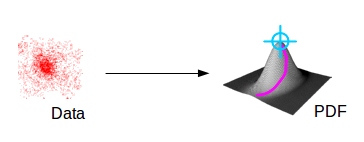

Consideramos un conjunto de puntos. (Por ejemplo la distribución de píxeles a partir de la retroproyección de histograma). Se le define una pequeña ventana y la idea es mover esa ventana al área de máxima densidad de píxeles (o número máximo de puntos). Finalmente lo que obtenemos es una ventana con la máxima distribución de píxeles.

In [2]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
# %matplotlib inline
%matplotlib

# Importamos las librerías necesarias
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Using matplotlib backend: Qt5Agg


### Definición de la ROI inicial

In [3]:
# Puntero al video
cap = cv.VideoCapture('slow_traffic_small.mp4')

# Tomamos el primer frame del video (donde vamos a definir la ROI)
#-----------------------------------------------------------------
ret,frame = cap.read()

# Definimos la ubicación inical de la ventana de seguimiento
#-----------------------------------------------------------
# r,h,c,w - Región de la imagen (valores harcodeados)
x, y, w, h = 300, 200, 100, 50
track_window = (x, y, w, h)

# Una vez definida la ROI recortamos esa parte de la imagen que utilizaremos para seguimiento
#--------------------------------------------------------------------------------------------
roi = frame[y:y+h, x:x+w]
# Pasamos la ROI a HSV (los valores de H son más estables a cambios de intensidad)
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
# Definimos una máscara para el histograma (Hue: 0..180, Saturation:60..255, Value:32..255)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
# Y calculamos el histograma sobre esa máscara (toma solo el Hue: tonalidad)
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
# Normalizamos el histograma (entre 0 y 255 según indica el flag cv.NORM_MINMAX)
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# Mostramos lo que se fue armando en relación a la ROI
#-----------------------------------------------------
plt.figure()
plt.imshow(roi)

# Muestro la imagen como para ver dónde definimos la ROI
#-------------------------------------------------------
plt.figure()
plt.imshow(frame)

### Loop de seguimiento

In [4]:
# Condición de terminación: 10 iteraciones o moverse al menos 1pt
#----------------------------------------------------------------
term_crit = ( cv.TERM_CRITERIA_COUNT | cv.TERM_CRITERIA_EPS, 10, 1 )

while(1):
    # Tomamos un nuevo frame
    #-----------------------
    ret ,frame = cap.read()

    # Mientras haya frames procesamos
    #--------------------------------
    if ret == True:
        # Pasamos el nuevo frame a HSV
        #-----------------------------
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        
        # Calculamos la proyección inversa del histograma
        #------------------------------------------------
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # En términos probabilísticos, esto es la probabilidad que un píxel corresponda a los
        # valores rescatados en el histograma de la imagen de testeo
        # "La retroproyección es una forma de registrar qué tan bien los píxeles de una imagen
        # dada se ajustan a la distribución de píxeles en un modelo de histograma." 
        # Para la retroproyección, se calcula el modelo de histograma de una característica y 
        # luego se usa para encontrar esta característica en una imagen.
        #
        # NOTAR que busca en toda la imagen
        #
        # Un histograma de imagen mide la distribución de color (y brillo) de los píxeles en una
        # imagen. Si se toma una imagen e se identifica una región de interés, por ejemplo una mano,
        # y se calcula el histograma de los píxeles de ese objeto. Luego, se toma ese histograma y 
        # una segunda imagen y esencialmente se invierte el proceso: se elijen los píxeles en la 
        # segunda imagen que coincidan con el histograma de la primera. Es este proceso inverso el 
        # que le da el nombre de retroproyección. Luego se asume que las áreas de la imagen en la 
        # segunda imagen que tienen la misma distribución de color que un objeto en la primera imagen
        # son una imagen del mismo (o similar) objeto.
        
        # Aplicamos meanshift para encontrar la nueva ubicación (precisa justamente que se le
        # ingrese una retroproyección del histograma del objeto)
        #-------------------------------------------------------
        ret, track_window = cv.meanShift(dst, track_window, term_crit)
        # La función implementa el algoritmo de búsqueda de objetos iterativos. Toma la 
        # retroproyección de entrada de un objeto y la posición inicial. Se calcula el 
        # centro de masa en la ventana de la imagen de retroproyección y el centro de la 
        # ventana de búsqueda se desplaza al centro de masa. El procedimiento se repite 
        # hasta que se completa el número especificado de iteraciones criterios.maxCount 
        # o hasta que el centro de la ventana se desplaza menos que criterios.epsilon.
        #
        # El tamaño o la orientación de la ventana de búsqueda no cambian durante la búsqueda
        #
        # NOTAR que se le pasa como parámetro la ventana de trackeo inicial
        
        # Dibujamos la ventana de seguimiento en la imagen
        #-------------------------------------------------
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv.imshow('Seguimiento',img2)

        k = cv.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv.imwrite(chr(k)+".jpg",img2)

    else:
        break

cv.destroyAllWindows()
cap.release()

## Seguimiento utilizando Camshift

#### La definición de la ROI es idéntica a Meanshift

In [6]:
# Puntero al video
cap = cv.VideoCapture('slow_traffic_small.mp4')

# Tomamos el primer frame del video (donde vamos a definir la ROI)
#-----------------------------------------------------------------
ret,frame = cap.read()

# Definimos la ubicación inical de la ventana de seguimiento
#-----------------------------------------------------------
# r,h,c,w - Región de la imagen (valores harcodeados)
x, y, w, h = 300, 200, 100, 50
track_window = (x, y, w, h)

# Una vez definida la ROI recortamos esa parte de la imagen que utilizaremos para seguimiento
#--------------------------------------------------------------------------------------------
roi = frame[y:y+h, x:x+w]
# Pasamos la ROI a HSV (los valores de H son más estables a cambios de intensidad)
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
# Definimos una máscara para el histograma (Hue: 0..180, Saturation:60..255, Value:32..255)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
# Y calculamos el histograma sobre esa máscara (toma solo el Hue: tonalidad)
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
# Normalizamos el histograma (entre 0 y 255 según indica el flag cv.NORM_MINMAX)
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX);


#### El loop de seguimiento cambia ligeramente

In [7]:
# Condición de terminación: 10 iteraciones o moverse al menos 1pt
#----------------------------------------------------------------
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 1, 10 )

while(1):
    ret, frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        # Aplicamos camshift al nuevo frame
        #----------------------------------
        ret, track_window = cv.CamShift(dst, track_window, term_crit)
        
        # Dibujamos la ventana sobre la imagen
        #=====================================
        
        # Con escalamiento y rotación de la ventana de seguimiento
        #---------------------------------------------------------
        #pts = cv.boxPoints(ret)                      # Encuentra los 4 vértices del rectángulo rotado
        #pts = np.int0(pts)                           # int0 (entero usado para indexado)
        #img2 = cv.polylines(frame,[pts],True, 255,2) # Dibujo del rectángulo
        
        # Con escalamiento de ventana - Sin rotación
        #-------------------------------------------
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        
        cv.imshow('Seguimiento',img2)
        
        k = cv.waitKey(30) & 0xff
        if k == 27:
            break
    else:
        break
cv.destroyAllWindows()
cap.release()

### Link de interés

- https://medium.com/@claudio.vindimian/understanding-and-implementing-the-camshift-object-tracking-algorithm-python-81587c24eda8